# Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

In [4]:
print(XTRA["date_forecast"].head())
print(YA["time"].head())

0   2019-06-02 22:00:00
1   2019-06-02 22:15:00
2   2019-06-02 22:30:00
3   2019-06-02 22:45:00
4   2019-06-02 23:00:00
Name: date_forecast, dtype: datetime64[ns]
0   2019-06-02 22:00:00
1   2019-06-02 23:00:00
2   2019-06-03 00:00:00
3   2019-06-03 01:00:00
4   2019-06-03 02:00:00
Name: time, dtype: datetime64[ns]


To align we can drop entry 0 for both Y and X

In [5]:
print(XTRB["date_forecast"].head())
print(YB["time"].head())

0   2019-01-01 00:00:00
1   2019-01-01 00:15:00
2   2019-01-01 00:30:00
3   2019-01-01 00:45:00
4   2019-01-01 01:00:00
Name: date_forecast, dtype: datetime64[ns]
0   2018-12-31 23:00:00
1   2019-01-01 00:00:00
2   2019-01-01 01:00:00
3   2019-01-01 02:00:00
4   2019-01-01 03:00:00
Name: time, dtype: datetime64[ns]


To align we remove 0 and 1 from Y and 0 from X

In [6]:
print(XTRC["date_forecast"].head())
print(YC["time"].head())

0   2019-01-01 00:00:00
1   2019-01-01 00:15:00
2   2019-01-01 00:30:00
3   2019-01-01 00:45:00
4   2019-01-01 01:00:00
Name: date_forecast, dtype: datetime64[ns]
0   2018-12-31 23:00:00
1   2019-01-01 00:00:00
2   2019-01-01 01:00:00
3   2019-01-01 02:00:00
4   2019-01-01 03:00:00
Name: time, dtype: datetime64[ns]


To align we remove 0 and 1 from Y and 0 from X

In [7]:
XTRA = XTRA.drop([0]).reset_index(drop=True)
XTRB = XTRB.drop([0]).reset_index(drop=True)
XTRC = XTRC.drop([0]).reset_index(drop=True)

YA = YA.drop([0]).reset_index(drop=True)
YB = YB.drop([0, 1]).reset_index(drop=True)
YC = YC.drop([0, 1]).reset_index(drop=True)

Need to reset index for aggregation function

In [8]:
for x in X_frames_test:
    print(x["date_forecast"].head())

0   2023-05-01 00:00:00
1   2023-05-01 00:15:00
2   2023-05-01 00:30:00
3   2023-05-01 00:45:00
4   2023-05-01 01:00:00
Name: date_forecast, dtype: datetime64[ns]
0   2023-05-01 00:00:00
1   2023-05-01 00:15:00
2   2023-05-01 00:30:00
3   2023-05-01 00:45:00
4   2023-05-01 01:00:00
Name: date_forecast, dtype: datetime64[ns]
0   2023-05-01 00:00:00
1   2023-05-01 00:15:00
2   2023-05-01 00:30:00
3   2023-05-01 00:45:00
4   2023-05-01 01:00:00
Name: date_forecast, dtype: datetime64[ns]


drop 0 since we want to match on the "whole" hour.

In [9]:
for i in range(len(X_frames_test)):
    X_frames_test[i] = X_frames_test[i].drop([0]).reset_index(drop=True)

# Data clean up

In [10]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, data_agg.stocastic_median)
   mean = data_agg.gen_agg(mean, "mean")

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = X_frames_test[j].drop(columns=["date_calc"])
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])




In [11]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))



x,y:  34059 34059
x,y:  32817 32817
x,y:  26070 26070


## Cleaning Y-data

### B targets:

Start | End
--- | ---
2019-03-24 00:00:00 | 2019-03-28 00:00:00
2019-05-31 00:00:00 | 2019-06-03 14:00:00
2019-10-28 14:00:00 | 2019-10-30 23:00:00
2020-02-23 17:00:00 | 2020-03-06 06:00:00
2020-03-26 14:00:00 | 2020-03-27 22:00:00
2020-04-02 03:00:00 | 2020-04-16 08:00:00
2020-07-12 23:00:00 | 2020-08-25 23:00:00
2020-09-24 14:00:00 | 2020-09-25 23:00:00
2021-01-15 10:00:00 | 2021-04-19 09:00:00
2021-04-29 00:00:00 | 2021-05-01 23:00:00
2021-06-05 03:00:00 | 2021-06-07 08:00:00
2021-06-13 04:00:00 | 2021-06-14 10:00:00
2021-06-22 03:00:00 | 2021-06-24 08:00:00
2021-07-03 15:00:00 | 2021-07-06 07:00:00
2021-08-26 00:00:00 | 2021-09-03 22:00:00
2021-09-08 15:00:00 | 2021-09-14 13:00:00
2021-09-19 02:00:00 | 2021-09-27 10:00:00
2021-01-30 15:00:00 | 2022-02-04 09:00:00
2022-02-10 21:00:00 | 2022-02-13 07:00:00
2022-02-16 14:00:00 | 2022-02-24 06:00:00
2022-03-19 15:00:00 | 2022-04-13 06:00:00
2022-12-05 17:00:00 | 2023-01-05 08:00:00
2023-02-24 01:00:00 | 2023-02-27 05:00:00
2023-03-07 10:00:00 | 2023-03-10 01:00:00
2023-03-25 23:00:00 | 2023-03-28 02:00:00

# Feature engineering

In [12]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i].drop(columns=['date_forecast'], inplace=True)

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i].drop(columns=['date_forecast'], inplace=True)

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

for i in range(len(X_train)):
     X_train[i] = OHE.one_hot_encode(X_train[i], ['dew_or_rime:idx', 'precip_type_5min:idx'])

for i in range(len(X_frames_test)):
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], ['dew_or_rime:idx', 'precip_type_5min:idx'])



In [13]:
X_train[0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
absolute_humidity_2m:gm3,34059.0,6.322364,2.799469,0.700000,4.200000,5.825000e+00,8.250000,1.740000e+01
air_density_2m:kgm3,34059.0,1.253278,0.037206,1.145000,1.227500,1.251500e+00,1.277250,1.426000e+00
ceiling_height_agl:m,27944.0,2968.545654,2557.649414,27.875000,1127.468750,1.979925e+03,4152.162598,1.229490e+04
clear_sky_energy_1h:J,34059.0,552703.625000,848353.312500,0.000000,0.000000,1.964755e+04,902072.968750,2.998650e+06
clear_sky_rad:W,34059.0,153.528702,236.248672,0.000000,0.000000,4.300000e+00,249.774994,8.338000e+02
cloud_base_agl:m,31705.0,1727.325317,1802.182373,27.799999,583.000000,1.147200e+03,2082.824951,1.166355e+04
dew_point_2m:K,34059.0,275.971863,6.892369,251.000000,271.299988,2.760000e+02,281.349976,2.937000e+02
diffuse_rad:W,34059.0,42.072437,62.838772,0.000000,0.000000,2.200000e+00,70.750000,3.355500e+02
diffuse_rad_1h:J,34059.0,151460.609375,223527.250000,0.000000,0.000000,1.595988e+04,254801.750000,1.184026e+06
direct_rad:W,34059.0,52.630783,115.252907,0.000000,0.000000,0.000000e+00,34.075001,6.809500e+02


## Normalizing columns for neural network

In [14]:
X_train[0].isna().sum()

absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m               6115
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                   2354
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0
precip_5min:mm                        0
pressure_100m:hPa                     0
pressure_50m:hPa                      0
prob_rime:p                           0


In [15]:
X_train[0].drop(columns=["snow_density:kgm3", "elevation:m"], inplace=True)
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}
X_train[0].fillna(value=values, inplace=True)
X_train[0].isna().sum()

absolute_humidity_2m:gm3          0
air_density_2m:kgm3               0
ceiling_height_agl:m              0
clear_sky_energy_1h:J             0
clear_sky_rad:W                   0
cloud_base_agl:m                  0
dew_point_2m:K                    0
diffuse_rad:W                     0
diffuse_rad_1h:J                  0
direct_rad:W                      0
direct_rad_1h:J                   0
effective_cloud_cover:p           0
fresh_snow_12h:cm                 0
fresh_snow_1h:cm                  0
fresh_snow_24h:cm                 0
fresh_snow_3h:cm                  0
fresh_snow_6h:cm                  0
is_day:idx                        0
is_in_shadow:idx                  0
msl_pressure:hPa                  0
precip_5min:mm                    0
pressure_100m:hPa                 0
pressure_50m:hPa                  0
prob_rime:p                       0
rain_water:kgm2                   0
relative_humidity_1000hPa:p       0
sfc_pressure:hPa                  0
snow_depth:cm               

In [16]:
import tensorflow as tf

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train[0])

first = np.array(X_train[0][:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[    7.7      1.23  1718.62     0.       0.    1718.62   280.3      0.
      0.       0.       0.      99.3      0.       0.       0.       0.
      0.       0.       1.    1005.97     0.     993.45   999.45     0.
      0.      70.7   1005.47     0.       0.       0.       0.2    351.51
     -4.07     0.     286.45   100.   40901.43     3.55    -3.55    -0.3
      0.      -0.26     0.97     0.49    -0.87     0.       1.       0.
      1.       0.       0.       0.  ]]

Normalized: [[ 0.49 -0.71 -0.62 -0.65 -0.65 -0.26  0.63 -0.67 -0.68 -0.46 -0.46  0.93
  -0.15 -0.09 -0.19 -0.1  -0.12 -1.03  0.96 -0.28 -0.2  -0.26 -0.27 -0.08
  -0.25 -0.24 -0.28 -0.16  0.   -0.05  0.46  1.72 -0.17 -0.54  0.98  0.77
   0.47  0.28 -1.46 -0.47 -0.01 -0.37  1.37  0.71 -1.25 -0.09  0.19 -0.17
   0.24 -0.22 -0.07 -0.08]]


# Training the model

In [17]:
def build_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(64, activation="relu", input_shape=[len(X_train[0].keys())]),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    optim = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss="mse", optimizer=optim, metrics=["mae", "mse"])

    return model

In [18]:
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.2, random_state=None)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.2, random_state=None)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.2, random_state=None)

In [19]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 52)                105       
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                3392      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7722 (30.17 KB)
Trainable params: 7617 (29.75 KB)
Non-trainable params: 105 (424.00 Byte)
_________________________________________________________________


In [27]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(
    X_train[0],
    Y_train[0],
    validation_split=0.2,
    epochs=1000, 
    callbacks=[early_stop])

Epoch 1/1000
852/852 [==============================] - 1s 590us/step - loss: 189905.7500 - mae: 214.6506 - mse: 189905.7500 - val_loss: 125917.6797 - val_mae: 170.5530 - val_mse: 125917.6797
Epoch 2/1000
852/852 [==============================] - 0s 580us/step - loss: 189355.3125 - mae: 214.4411 - mse: 189355.3125 - val_loss: 129296.3750 - val_mae: 171.8618 - val_mse: 129296.3750
Epoch 3/1000
852/852 [==============================] - 1s 596us/step - loss: 188855.0938 - mae: 214.1687 - mse: 188855.0938 - val_loss: 125903.1484 - val_mae: 168.2950 - val_mse: 125903.1484
Epoch 4/1000
852/852 [==============================] - 0s 563us/step - loss: 187641.4688 - mae: 213.7147 - mse: 187641.4688 - val_loss: 129366.8047 - val_mae: 172.4037 - val_mse: 129366.8047
Epoch 5/1000
852/852 [==============================] - 0s 578us/step - loss: 187260.0156 - mae: 213.3629 - mse: 187260.0156 - val_loss: 134450.2188 - val_mae: 177.5134 - val_mse: 134450.2188
Epoch 6/1000
852/852 [==================

In [21]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

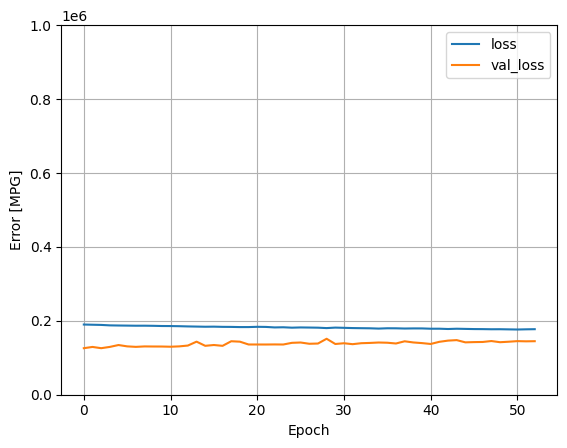

In [28]:
plot_loss(history)

In [29]:
model.evaluate(x_val_a, y_val_a)

213/213 [==============================] - 0s 417us/step - loss: 162869.4062 - mae: 195.8642 - mse: 162869.4062


[162869.40625, 195.86424255371094, 162869.40625]

In [30]:
y = model.predict(x_val_a)

213/213 [==============================] - 0s 392us/step


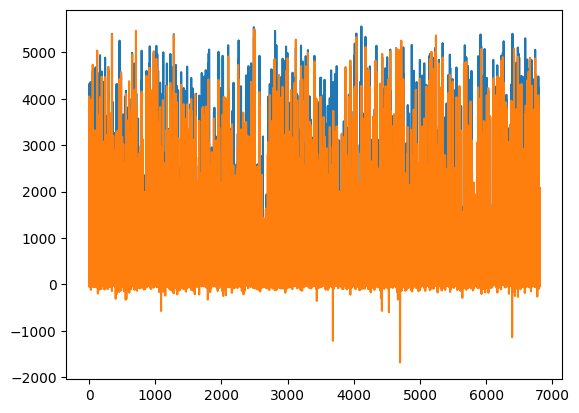

In [31]:
y_val_a.index = range(0, y_val_a.shape[0])
#y.index = range(0, y.shape[0])
plt.plot(y_val_a)
plt.plot(y)


In [58]:
print(len(x_val_a), len(y))

5934 5934


# Make predictions

In [ ]:
# Do some more stuff

# Evaluate prediction

In [ ]:

# Evaluate the model based on the validation data

mse_a = mean_squared_error(y_val_a, model_a.predict(x_val_a))
print("MSE for A: ", mse_a)
mse_b = mean_squared_error(y_val_b, model_b.predict(x_val_b))
print("MSE for B: ", mse_b)
mse_c = mean_squared_error(y_val_c, model_c.predict(x_val_c))
print("MSE for C: ", mse_c)
print("Mean MSE: ", (mse_a + mse_b + mse_c) / 3)

# Evaluate the predictions

score_a = model_a.score(x_val_a, y_val_a)
score_b = model_b.score(x_val_b, y_val_b)
score_c = model_c.score(x_val_c, y_val_c)

print("Score A: ", score_a)
print("Score B: ", score_b)
print("Score C: ", score_c)
print('')

# Get feature importance scores
models = [(model_a, 'A'), (model_b, 'B'), (model_c, 'C')]
for model in models:

    feature_importance_scores = model[0].feature_importances_

# Create a DataFrame to associate features with their importance scores
    feature_importance_df1 = pd.DataFrame({'Feature': x_train_a.columns, 'Importance': feature_importance_scores})

# Sort features by importance in descending order
    feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance scores
    
    print(f'Model {model[1]}')
    print(feature_importance_df1.head(10))
    print('')


# Create submission

In [ ]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submission.csv', index=False)